In [1]:
import torch
import torch.nn.functional as F
import torchvision

import matplotlib.pyplot as plt

from torch import nn, optim
from torchvision.utils import make_grid, save_image

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
def show_batch(batch, fname=None):
    im = torchvision.utils.make_grid(batch)
    plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))
    
    if fname:
        save_image(im, fname)

In [3]:
batch_size = 32

transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
])

train_data = torchvision.datasets.MNIST(
    '/media/akir/DATA/ml-data/',
    train=True,
    download=True,
    transform=transform,
)

digit1 = 0
digit2 = 8

bad_digit = 2

train_idxs = np.where((train_data.targets == digit1) | (train_data.targets == digit2))[0]
train_dataset = torch.utils.data.Subset(train_data, train_idxs)
train_dataset.dataset.targets[np.where(train_dataset.dataset.targets == digit1)] = 0
train_dataset.dataset.targets[np.where(train_dataset.dataset.targets == digit2)] = 1

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_data = torchvision.datasets.MNIST(
    '/media/akir/DATA/ml-data/',
    train=False,
    download=True,
    transform=transform,
)

test_idxs = np.where((test_data.targets == digit1) | (test_data.targets == digit2))[0]
test_dataset = torch.utils.data.Subset(test_data, test_idxs)
test_dataset.dataset.targets[np.where(test_dataset.dataset.targets == digit1)] = 0
test_dataset.dataset.targets[np.where(test_dataset.dataset.targets == digit2)] = 1

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


bad_data = torchvision.datasets.MNIST(
    '/media/akir/DATA/ml-data/',
    train=False,
    download=True,
    transform=transform,
)

bad_idxs = np.where(bad_data.targets == bad_digit)[0]
bad_dataset = torch.utils.data.Subset(bad_data, bad_idxs)
bad_dataloader = torch.utils.data.DataLoader(bad_dataset, batch_size=batch_size, shuffle=True)

In [4]:
images, labels = next(iter(train_dataloader))
print(f'Labels: {labels}')
#show_batch(images, 'images/mnist-0-8.jpg')

Labels: tensor([1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0,
        0, 1, 0, 1, 1, 1, 1, 1])


In [5]:
class ConvNet(nn.Module):
    def __init__(self, p):
        super().__init__()
        self.p = p
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout = nn.Dropout(self.p)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [6]:
def train(dataloader, model, optimizer, criterion, device, n_epochs=50, losses=[]):

    model.train()

    for epoch in range(n_epochs):
        
        for i, batch in enumerate(dataloader):
            X, y = batch
            
            X = X.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            y_pred = model(X)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            
            losses.append(loss)

        print(f'Epoch: {epoch}, loss: {loss}')


In [7]:
n_epochs = 5
lr = 0.005
p = 0.75

model = ConvNet(p).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

train(train_dataloader, model, optimizer, criterion, device, n_epochs)

Epoch: 0, loss: 0.03993351757526398
Epoch: 1, loss: 0.02182382345199585
Epoch: 2, loss: 0.015014871023595333
Epoch: 3, loss: 0.02163991890847683
Epoch: 4, loss: 0.0667407214641571


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels: tensor([0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0,
        1, 1, 0, 0, 0, 1, 1, 0])


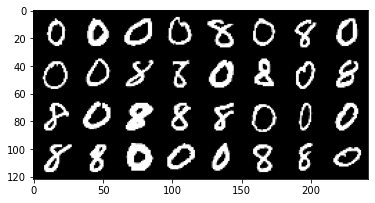

In [8]:
images, labels = next(iter(test_dataloader))
print(f'Labels: {labels}')
show_batch(images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])


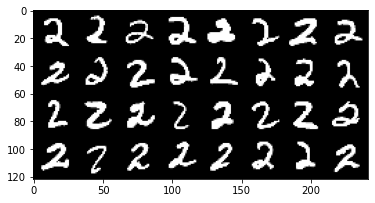

In [9]:
bad_images, bad_labels = next(iter(bad_dataloader))
print(f'Labels: {bad_labels}')
show_batch(bad_images)

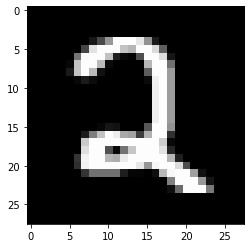

In [21]:
bad_image = bad_images[0]
plt.imshow(bad_image[0], cmap='gray')
#plt.savefig('images/two.jpg')

In [36]:
# standard gaussian noise

#bad_image = torch.randn(size=(1, 28, 28))
#plt.imshow(bad_image[0], cmap='gray')
#plt.savefig('images/gaussian-noise.jpg')

In [11]:
# image in distribution

#bad_image = images[0]
#plt.imshow(bad_image[0], cmap='gray')
#plt.savefig('images/eight.jpg')

## Normal

In [28]:
model = model.eval()
y_hat = model(bad_image[:, None].to(device))
outputs = torch.exp(F.log_softmax(y_hat, dim=1))
outputs[0][0].item(), outputs[0][1].item()

(0.3517029583454132, 0.6482970714569092)

## MC Dropout

In [29]:
def mc_predict(model, device, X, T=1000):
    model = model.train()
    outputs = torch.zeros(T, 2).to(device)

    for i in range(T):
        y_hat = model(X.unsqueeze(0).to(device))
        y_pred = F.log_softmax(y_hat, dim=1)
        outputs[i] = torch.tensor([y_pred[0][0].item(), y_pred[0][1].item()])
    
    return torch.exp(outputs)

In [30]:
T = 1000
mcs = mc_predict(model, device, bad_image, T)

### Variation ratio

In [31]:
mode = torch.mode(mcs.argmax(axis=1))[0]
mode

tensor(1, device='cuda:0')

In [32]:
n_mode = torch.sum(mcs.argmax(axis=1) == mode)
n_mode

tensor(818, device='cuda:0')

In [33]:
# max = 0.5 when classes are sampled equally likely
# min = 0   when only a single class is sampled
variation_ratio = 1. - n_mode.type(torch.float)/T
variation_ratio

tensor(0.1820, device='cuda:0')

### Predictive entropy

In [35]:
# min = 0  when only a single class is sampled
# max = ?  when classes are sampled equally likely
-torch.sum(mcs.mean(axis=0)*torch.log(mcs.mean(axis=0)))

tensor(0.4130, device='cuda:0')

## Testing

In [19]:
model.train()
images, labels = next(iter(test_dataloader))
y_hat = model(images.to(device))
torch.sum(torch.argmax(y_hat, axis=1) == labels.to(device)), torch.argmax(y_hat, axis=1), labels

(tensor(32, device='cuda:0'),
 tensor([1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
         1, 0, 0, 1, 0, 1, 1, 0], device='cuda:0'),
 tensor([1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
         1, 0, 0, 1, 0, 1, 1, 0]))

In [20]:
model.eval()
images, labels = next(iter(bad_dataloader))
y_hat = model(images.to(device))
torch.sum(torch.argmax(y_hat, axis=1) == labels.to(device)), torch.argmax(y_hat, axis=1), labels

(tensor(0, device='cuda:0'),
 tensor([0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
         1, 1, 0, 1, 1, 1, 1, 1], device='cuda:0'),
 tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2]))